In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
import warnings
warnings.filterwarnings('ignore')
import pvlib
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [299]:
forecast_weather = pd.read_csv('../../Data\\capstone\\weather/solar_forecast_weather.csv')
solar = pd.read_csv('../../Data\\capstone\\weather/solar_power_2204.csv')
real_weather = pd.read_csv('../../Data/capstone/total_eda_real.csv')
solar_2 = pd.read_csv('../../Data/capstone/발전소/하동_eda.csv')

In [300]:
def time_change(data, Forecast_time):
    """
    data = forecast가 있는 데이터
    Forecast_time = 예보시간

    return = 예보시간을 기준으로 데이터를 정렬한 데이터
    """
    data[Forecast_time] = pd.to_datetime(data[Forecast_time])
    data['real_time'] = data.apply(lambda row: row['Forecast time'] + datetime.timedelta(hours=row['forecast']), axis=1)
    forecast_weather_eda = data.groupby(['real_time']).mean().drop('forecast', axis=1)
    forecast_weather_eda.reset_index(inplace=True)
    return forecast_weather_eda

In [301]:
solar['datetime'] = pd.to_datetime(solar['datetime'])
solar.target.replace(65535.0, solar.target.mean(), inplace=True)
solar['month'] = solar.datetime.dt.month
solar['hour'] = solar.datetime.dt.hour
solar['year'] = solar.datetime.dt.year
solar['day'] = solar.datetime.dt.day
solar_eda = solar.groupby(['year','month','day','hour']).sum().reset_index()
solar_eda['date'] = pd.to_datetime(solar_eda[['year', 'month', 'day', 'hour']])

In [302]:
eda_forecast = time_change(forecast_weather, 'Forecast time')

In [303]:
reg = real_weather[real_weather['지점명'] =='순천']

In [304]:
eda_weather = reg.drop(['지점', '지점명'], axis=1)
eda_weather['일시'] = pd.to_datetime(eda_weather['일시'])
eda_weather['hour'] = eda_weather['일시'].dt.hour
eda_weather['month'] = eda_weather['일시'].dt.month
eda_weather['year'] = eda_weather['일시'].dt.year

In [305]:
eda_weather.set_index('일시', inplace=True)

In [306]:
total_time = pd.date_range(start='2021-01-01 00:00:00', end='2022-04-30 23:00:00', freq='H')

In [307]:
solar_2.date = pd.to_datetime(solar_2.date)

In [308]:
solar_2.set_index('date', inplace=True)

In [309]:
x = eda_weather.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

In [310]:
y = solar_2.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

In [311]:
y.drop('hour', axis=1 , inplace=True)

In [312]:
x.drop(['위도','경도'], axis=1, inplace=True)

In [313]:
total = pd.concat([x, y], axis = 1)

In [314]:
total.interpolate()

,기온,풍속,풍향,습도,강수량,hour,month,year,value
2021-01-01 00:00:00,-2.3,3.8,290.0,81.0,0.0,0.0,1.0,2021.0,0.0
2021-01-01 01:00:00,-3.1,3.3,290.0,71.0,0.0,1.0,1.0,2021.0,0.0
2021-01-01 02:00:00,-3.7,3.6,290.0,73.0,0.0,2.0,1.0,2021.0,0.0
2021-01-01 03:00:00,-4.2,3.1,270.0,76.0,0.0,3.0,1.0,2021.0,0.0
2021-01-01 04:00:00,-4.2,2.4,270.0,76.0,0.0,4.0,1.0,2021.0,0.0
...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00,13.9,3.0,290.0,70.0,0.0,19.0,4.0,2022.0,144.0
2022-04-30 20:00:00,12.9,2.2,290.0,78.0,0.0,20.0,4.0,2022.0,0.0
2022-04-30 21:00:00,12.5,2.5,290.0,78.0,0.0,21.0,4.0,2022.0,0.0
2022-04-30 22:00:00,11.9,2.7,290.0,82.0,0.0,22.0,4.0,2022.0,0.0


In [315]:
complete_date_rng = pd.date_range(start='2021-01-01', end='2022-04-30', freq='H')

# 누락된 시간 찾기
missing_dates = complete_date_rng.difference(total.index)

In [316]:
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [317]:
total_eda = total[(total.index>='2021-09-28') | (total.index <= '2021-09-22')]

In [318]:
total_eda_2 = total_eda[(total_eda.index <= '2022-01-14') | (total_eda.index >= '2022-01-17')]

In [319]:
date_counts = total_eda_2.resample('D').count()

In [320]:
date_counts

,기온,풍속,풍향,습도,강수량,hour,month,year,value
2021-01-01,24,24,24,24,24,24,24,24,24
2021-01-02,24,24,24,24,24,24,24,24,24
2021-01-03,24,24,24,24,24,24,24,24,24
2021-01-04,24,24,24,24,24,24,24,24,24
2021-01-05,24,24,24,24,24,24,24,24,24
...,...,...,...,...,...,...,...,...,...
2022-04-26,24,24,24,24,24,24,24,24,24
2022-04-27,24,24,24,24,24,24,24,24,24
2022-04-28,24,24,24,24,24,24,24,24,24
2022-04-29,24,24,24,24,24,24,24,24,24


In [321]:
extra_hourly_data = date_counts[date_counts['month'] < 24]

extra_hourly_data

,기온,풍속,풍향,습도,강수량,hour,month,year,value
2021-09-22,1,1,1,1,1,1,1,1,1
2021-09-23,0,0,0,0,0,0,0,0,0
2021-09-24,0,0,0,0,0,0,0,0,0
2021-09-25,0,0,0,0,0,0,0,0,0
2021-09-26,0,0,0,0,0,0,0,0,0
2021-09-27,0,0,0,0,0,0,0,0,0
2022-01-01,23,23,23,23,23,23,23,23,24
2022-01-14,1,1,1,1,1,1,1,1,1
2022-01-15,0,0,0,0,0,0,0,0,0
2022-01-16,0,0,0,0,0,0,0,0,0


In [322]:
total_eda_2 = total_eda_2[total_eda_2.index != '2022-01-14']
total_eda_2 = total_eda_2[total_eda_2.index != '2021-09-22']

In [323]:
total_eda_2.interpolate(inplace=True, method='linear')

In [324]:
total_eda_2

,기온,풍속,풍향,습도,강수량,hour,month,year,value
2021-01-01 00:00:00,-2.3,3.8,290.0,81.0,0.0,0.0,1.0,2021.0,0.0
2021-01-01 01:00:00,-3.1,3.3,290.0,71.0,0.0,1.0,1.0,2021.0,0.0
2021-01-01 02:00:00,-3.7,3.6,290.0,73.0,0.0,2.0,1.0,2021.0,0.0
2021-01-01 03:00:00,-4.2,3.1,270.0,76.0,0.0,3.0,1.0,2021.0,0.0
2021-01-01 04:00:00,-4.2,2.4,270.0,76.0,0.0,4.0,1.0,2021.0,0.0
...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00,13.9,3.0,290.0,70.0,0.0,19.0,4.0,2022.0,144.0
2022-04-30 20:00:00,12.9,2.2,290.0,78.0,0.0,20.0,4.0,2022.0,0.0
2022-04-30 21:00:00,12.5,2.5,290.0,78.0,0.0,21.0,4.0,2022.0,0.0
2022-04-30 22:00:00,11.9,2.7,290.0,82.0,0.0,22.0,4.0,2022.0,0.0


In [325]:
def clear_sky_model_pred(longitude, latitude, capacity, weather):
    """
    input :
        longitude : 경도
        latitude : 위도
        capacity : 용량(단위 : w)
        weather : 날씨 데이터 (index가 날짜인 데이터)
    output :
        cs : ghi, dni, dhi
        generation : 발전량
    """
    location = pvlib.location.Location(latitude, longitude, tz='Asia/Seoul')
    start_date = weather.index.min()
    end_date = weather.index.max()

    # 시간대가 Asia/Seoul로 설정되어 있는지 확인하고, 아니라면 설정한다.
    if weather.index.tz is None or weather.index.tz.zone != 'Asia/Seoul':
        weather = weather.tz_localize('Asia/Seoul')

    times = pd.date_range(start=start_date, end=end_date, freq='1H', tz='Asia/Seoul')
    solpos = location.get_solarposition(times=times)
    dni_extra = pvlib.irradiance.get_extra_radiation(times)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(location.altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure) 
    tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)

    solis_clearsky = pvlib.clearsky.simplified_solis(solpos['apparent_zenith'], am_abs, tl)
    cs = location.get_clearsky(times, model='simplified_solis')
    
    # cs의 시간대를 None으로 설정
    cs = cs.tz_localize(None)

    system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                    module_parameters={'pdc0': capacity, 'gamma_pdc': -0.004}, 
                                    inverter_parameters={'pdc0': capacity},
                                    modules_per_string=1, strings_per_inverter=1,
                                    temperature_model_parameters={'a': -3.56, 'b': -0.075, 'deltaT': 3})
    mc = pvlib.modelchain.ModelChain(system, location, spectral_model='no_loss', aoi_model='no_loss')

    mc.run_model(pd.concat([solis_clearsky, weather], axis=1))

    return cs, pd.DataFrame(mc.results.ac)

In [326]:
latitude, longitude = reg[['위도', '경도']].iloc[0]

In [327]:
weather_input = total_eda_2.drop(['month', 'year', 'hour', 'value'], axis=1)

In [328]:
radi, _ = clear_sky_model_pred(longitude, latitude, 1000, weather_input)

In [329]:
radi

,ghi,dni,dhi
2021-01-01 00:00:00,0.000000,0.000000,0.00000
2021-01-01 01:00:00,0.000000,0.000000,0.00000
2021-01-01 02:00:00,0.000000,0.000000,0.00000
2021-01-01 03:00:00,0.000000,0.000000,0.00000
2021-01-01 04:00:00,0.000000,0.000000,0.00000
...,...,...,...
2022-04-30 19:00:00,15.257757,126.590259,19.22342
2022-04-30 20:00:00,0.000000,0.000000,0.00000
2022-04-30 21:00:00,0.000000,0.000000,0.00000
2022-04-30 22:00:00,0.000000,0.000000,0.00000


In [330]:
total_df = pd.concat([total_eda_2, radi], axis=1)

In [331]:
total_df.interpolate(inplace=True, method='linear')

In [332]:
y = total_df.value / 5
x = total_df.drop('value', axis=1)

In [333]:
slice = 455 * 24

In [334]:
x_train = x.iloc[:slice]
x_test = x.iloc[slice:]
y_train = y.iloc[:slice]
y_test = y.iloc[slice:]

In [335]:
sc_x = StandardScaler()
sc_y = StandardScaler()

In [336]:
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

sc_x.fit(x_train)

x_train = sc_x.transform(x_train)
x_test = sc_x.transform(x_test)

In [337]:
sc_y.fit(y_train.values.reshape(-1,1))

y_train = sc_y.transform(y_train.values.reshape(-1,1))
y_train = y_train.flatten()

In [338]:
y_test = sc_y.transform(y_test.values.reshape(-1,1))

In [339]:
print(x_train.shape)
print(x_test.shape)

(10920, 11)
(720, 11)


----
# Model Train

In [340]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [341]:
from lightgbm import LGBMRegressor

In [342]:
dt = DecisionTreeRegressor(max_depth=5)

In [343]:
svm_params = {
    "kernel" : ['rbf', 'linear'],
    "C" : [0.1, 0.5, 1],
    "gamma" : [0.05, 0.1, 1]
}

In [344]:
params = {
    'n_estimators' : [5,50,100],
    'max_depth': [3,5,7],
    'min_samples_leaf':[4,6],
    'min_samples_split':[4,8,16]
}

In [345]:
lg_params = {
    'n_estimators' : [5,10,15],
    'max_depth': [3,5,8],
    'learning_rate' : [0.01, 0.1, 0.3],
    'num_leaves' : [16, 32, 64]
}

In [346]:
rf = RandomForestRegressor()
lg = LGBMRegressor(n_jobs = -1)
svr = SVR()

In [347]:
grid_cv_rf = GridSearchCV(rf, param_grid=params,
                      cv=3, n_jobs=2)
grid_cv_rf.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=2,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 8, 16],
                         'n_estimators': [5, 50, 100]})

In [348]:
grid_cv_lg = GridSearchCV(lg, param_grid=lg_params,
                      cv=3, n_jobs=2)
grid_cv_lg.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 8], 'n_estimators': [5, 10, 15],
                         'num_leaves': [16, 32, 64]})

grid_cv_svr = GridSearchCV(svr, param_grid=svm_params,cv=3, n_jobs=-1)
grid_cv_svr.fit(x_train, y_train)

----

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

optimizer =  tf.keras.optimizers.Adam(learning_rate=0.001)

In [349]:
import tensorflow as tf

In [350]:
from tensorflow.keras import layers, models

In [351]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))


In [352]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [353]:
dnn_his = model.fit(x_train, y_train, epochs=240, batch_size=24, verbose=0)

(0.0, 1.0)

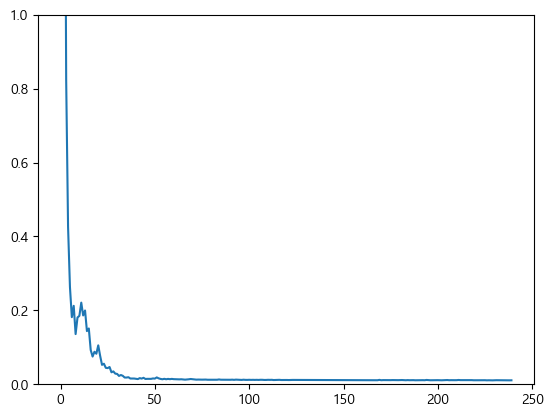

In [354]:
plt.plot(dnn_his.history['loss'])
plt.ylim(0,1)

In [355]:
ann_pred = model.predict(x_test)

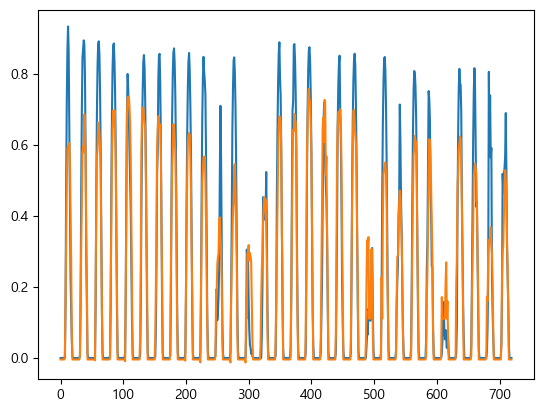

In [356]:
plt.plot(y_test)
plt.plot(ann_pred)

In [357]:
# import LSTM
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

In [358]:
# LSTM 모델 정의
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(x_train.shape[1],1), return_sequences=True))
lstm_model.add(LSTM(128))
lstm_model.add(layers.Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [359]:
lstm_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 11, 64)            16896     
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 129       
Total params: 115,841
Trainable params: 115,841
Non-trainable params: 0
_________________________________________________________________


In [360]:
lstm_his = lstm_model.fit(x_train.values.reshape(-1,11,1), y_train, epochs=240, batch_size=24, verbose=0)

In [361]:
lstm_pred = lstm_model.predict(x_test.values.reshape(-1,11,1))

-----
# Model Prediction

In [362]:
window_size = 24 * 365

In [363]:
from tqdm import tqdm

In [371]:
grid_cv_rf.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_lg.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
model.fit(x_train[:window_size], y_train[:window_size], batch_size=24, epochs=240, verbose=0)
lstm_model.fit(x_train[:window_size].values.reshape(-1,11,1), y_train[:window_size], epochs=240, batch_size=24, verbose=0)

In [373]:
predictions_list = []

x_train_copy = x_train.copy()
y_train_copy = y_train.copy()

for i in tqdm(range(0, len(x_test), 24)):
    x_test_window = x_test[i:i+24]
    y_test_window = y_test[i:i+24]

    predictions_rf = grid_cv_rf.best_estimator_.predict(x_test_window)
    predictions_lg = grid_cv_lg.best_estimator_.predict(x_test_window)
    # predictions_svr = grid_cv_svr.best_estimator_.predict(x_test_window)
    predictions_lstm = lstm_model.predict(x_test_window.values.reshape(-1,11,1))
    predictions_dnn = model.predict(x_test_window)

    for j in range(24):
        # predictions_list.append([predictions_rf[j], predictions_et[j], predictions_lg[j], predictions_lstm[0][j]])
        # predictions_list.append([predictions_rf[j], predictions_lg[j], predictions_svr[j]])
        predictions_list.append([predictions_rf[j], predictions_lg[j], predictions_dnn[j], predictions_lstm[j]])


    x_train_copy = np.concatenate((x_train_copy, x_test_window), axis=0)
    y_train_copy = np.concatenate((y_train_copy, y_test_window.ravel()), axis=0)

    grid_cv_rf.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    grid_cv_lg.best_estimator_.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size])
    model.fit(x_train[i+24:i+24+window_size], y_train_copy[i+24:i+24+window_size], epochs=240, verbose=0, batch_size=24)
    lstm_model.fit(x_train[i+24:i+24+window_size].values.reshape(-1,11,1), y_train_copy[i+24:i+24+window_size], epochs=240, verbose=0, batch_size=24)

predictions_array = np.array(predictions_list)

100%|██████████| 30/30 [3:49:48<00:00, 459.61s/it]  


In [375]:
from math import *
import random
import sys

In [473]:
class Particle:
    def __init__(self, max_iter, initial_position=None):
        if initial_position:  # If an initial position is provided
            self.position = initial_position.copy()
        else:
            self.position = [0.0]*4  # particle current position
        self.velocity = [random.uniform(-1, 1) for _ in range(4)]  # particle current velocity
        self.best_position = [0.0]*4  # particle best position
        self.fitness = sys.maxsize   # particle fitness
        self.best_fitness = sys.maxsize  # particle best fitness
        self.iteration = 0  # iteration count
        self.max_iter = max_iter

    def evaluate_fitness(self, fitness_func):
        self.fitness = fitness_func(self.position)
        if self.fitness < self.best_fitness:
            self.best_position = self.position.copy()
            self.best_fitness = self.fitness

    def update_velocity(self, global_best_position):
        w_min = 0.5
        w_max = 1
        self.iteration += 1
        w = w_max - ((w_max - w_min) * self.iteration / self.max_iter)
        c1 = 1
        c2 = 1.5
        for i in range(len(self.position)):
            r1 = random.random()
            r2 = random.random()
            cognitive_velocity = c1 * r1 * (self.best_position[i] - self.position[i])
            social_velocity = c2 * r2 * (global_best_position[i] - self.position[i])
            self.velocity[i] = w * self.velocity[i] + cognitive_velocity + social_velocity

    def update_position(self, bounds):
        for i in range(len(self.position)):
            self.position[i] += self.velocity[i]
            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]
            elif self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]

class PSO:
    def __init__(self, fitness_function, bounds, num_particles, max_iter, initial_positions=None):
        self.fitness_func = fitness_function
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.global_best_position = [0.0]*4
        self.global_best_fitness = sys.maxsize
        if initial_positions:
            self.swarm = [Particle(max_iter, initial_position=pos) for pos in initial_positions]
        else:
            self.swarm = [Particle(max_iter) for _ in range(num_particles)]

    def run_result(self):
        for i in range(self.max_iter):
            for j in range(self.num_particles):
                self.swarm[j].evaluate_fitness(self.fitness_func)
                if self.swarm[j].fitness < self.global_best_fitness:
                    self.global_best_position = self.swarm[j].position.copy()
                    self.global_best_fitness = self.swarm[j].fitness
            for j in range(self.num_particles):
                self.swarm[j].update_velocity(self.global_best_position)
                self.swarm[j].update_position(self.bounds)
        return self.global_best_position, self.global_best_fitness

lstm_model.fit(x_train[:window_size].reshape(-1, 8, 1), y_train[:window_size], epochs=100, verbose=0)

****
# Meta model Train

In [377]:
from sklearn.linear_model import LinearRegression

In [378]:
grid_cv_rf.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
grid_cv_lg.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
model.fit(x_train[:window_size], y_train[:window_size], epochs=240, verbose=0, batch_size=24)
# grid_cv_svr.best_estimator_.fit(x_train[:window_size], y_train[:window_size])
lstm_model.fit(x_train[:window_size].values.reshape(-1,11,1), y_train[:window_size], epochs=240, batch_size=24, verbose=0)

Epoch 1/240
365/365 [==============================] - 2s 5ms/step - loss: 0.0013 - mae: 0.0137
Epoch 2/240
365/365 [==============================] - 2s 4ms/step - loss: 6.5287e-04 - mae: 0.0097
Epoch 3/240
365/365 [==============================] - 2s 4ms/step - loss: 3.5413e-04 - mae: 0.0075
Epoch 4/240
365/365 [==============================] - 2s 5ms/step - loss: 2.3292e-04 - mae: 0.0063
Epoch 5/240
365/365 [==============================] - 2s 5ms/step - loss: 2.0666e-04 - mae: 0.0059
Epoch 6/240
365/365 [==============================] - 2s 5ms/step - loss: 1.9110e-04 - mae: 0.0057
Epoch 7/240
365/365 [==============================] - 2s 5ms/step - loss: 1.3864e-04 - mae: 0.0051
Epoch 8/240
365/365 [==============================] - 2s 4ms/step - loss: 1.1194e-04 - mae: 0.0045
Epoch 9/240
365/365 [==============================] - 2s 5ms/step - loss: 1.1618e-04 - mae: 0.0044
Epoch 10/240
365/365 [==============================] - 2s 5ms/step - loss: 1.6383e-04 - mae: 0.0059
Epo

In [379]:
train_predictions_list = []

# 훈련 데이터에 대한 예측 수집
for i in range(0, len(x_train), 24):
    x_train_window = x_train[i:i+24]

    train_predictions_rf = grid_cv_rf.best_estimator_.predict(x_train_window)
    train_predictions_lg = grid_cv_lg.best_estimator_.predict(x_train_window)
    train_predictions_dnn = model.predict(x_train_window)
    train_predictions_lstm = lstm_model.predict(x_train_window.values.reshape(-1,11,1))

    # train_predictions_svr = grid_cv_svr.best_estimator_.predict(x_train_window)

    # auto_arima_model.fit(y_train[:i+24])


    for j in range(24):
        # train_predictions_list.append([train_predictions_rf[j], train_predictions_et[j], train_predictions_lg[j], train_predictions_lstm[0][j]])
        # train_predictions_list.append([train_predictions_rf[j], train_predictions_lg[j], train_predictions_svr[j]])
        train_predictions_list.append([train_predictions_rf[j], train_predictions_lg[j], train_predictions_dnn[j], train_predictions_lstm[j]])

In [380]:
train_predictions_array = np.array(train_predictions_list)

In [381]:
def fitness_function(x, train_predictions_array, y_train):
    fitness = 0
    for i in range(4):
        fitness += train_predictions_array[:,i] * x[i]
    difference = y_train - fitness
    return np.sum(difference**2)

In [475]:
weights = np.array([3 if 11 <= i <= 13 else 1 for i in range(24)])

def weighted_fitness_function(x, train_predictions_array, y_train, weights):
    fitness = 0
    for i in range(4):
        fitness += train_predictions_array[:,i] * x[i]
    difference = y_train - fitness
    num_repeats = len(difference) // len(weights)
    extended_weights = np.tile(weights, num_repeats)
    weighted_difference = difference * extended_weights  # Corrected the weights shape here
    return np.sum(weighted_difference**2)


In [508]:
bound = [(-2,2) for _ in range(4)]

In [509]:
weight = list(np.linalg.inv(train_predictions_array.astype('float64').T.dot(train_predictions_array.astype('float64'))).dot(train_predictions_array.astype('float64').T).dot(y_train))

In [510]:
weight_initial = [weight for i in range(50)] 

In [511]:
pso_result = PSO(lambda x : weighted_fitness_function(x, train_predictions_array, y_train, weights),
                 bounds=bound,
                 num_particles=50,
                 max_iter=100,
                 initial_positions=weight_initial)


pso_result = PSO(lambda x : fitness_function(x, train_predictions_array, y_train), bounds=bound,num_particles=200, max_iter=500 )

In [512]:
best_position_price, best_fitness_price = pso_result.run_result()

In [513]:
optimal_result = (train_predictions_array * best_position_price).sum(axis=1)

In [514]:
from sklearn.metrics import mean_absolute_error

In [515]:
mean_absolute_error(y_train, optimal_result)

0.01011848616933947

In [516]:
meta_model = LinearRegression()

In [517]:
meta_model.fit(train_predictions_array, y_train)

LinearRegression()

In [518]:
best_position_price

[0.06902703667134726,
 -0.05818733341324565,
 -0.007754423490127695,
 0.9835196508652607]

In [519]:
meta_model.coef_

array([ 0.0482929 , -0.01803423, -0.01644089,  0.96746209])

----
# Meta model prediction

In [520]:
meta_result = meta_model.predict(predictions_array)

In [521]:
meta_result_2 = np.dot(best_position_price, predictions_array.T)

In [522]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

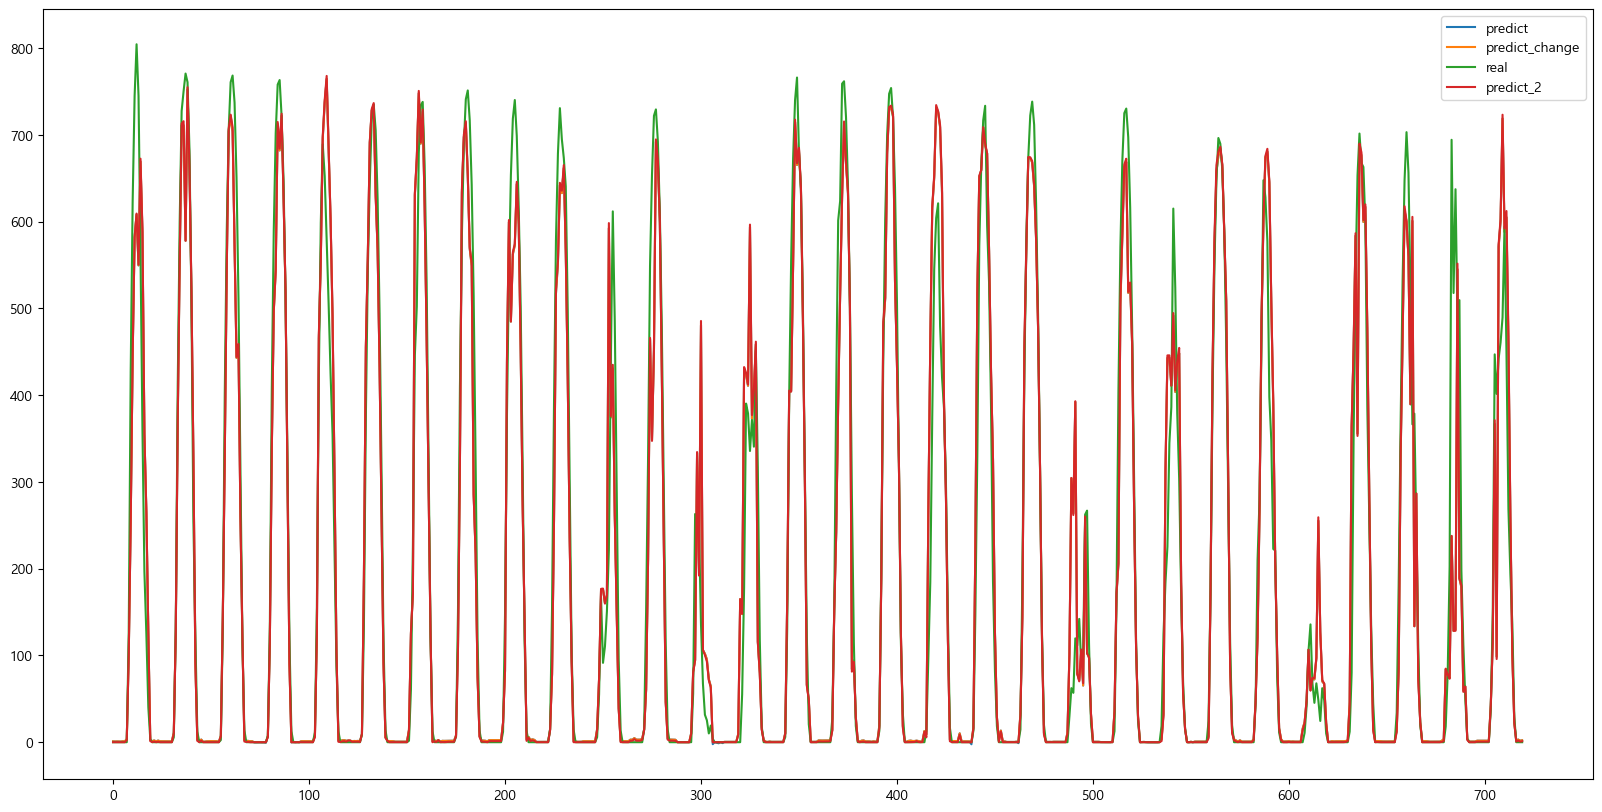

In [523]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(meta_result)), sc_y.inverse_transform(meta_result.reshape(-1,1)), label='predict')
plt.plot(np.arange(len(meta_result)), np.maximum(sc_y.inverse_transform(meta_result.reshape(-1,1)),0), label='predict_change')
plt.plot(np.arange(len(meta_result)), sc_y.inverse_transform(y_test), label='real')
plt.plot(np.arange(len(meta_result)), np.maximum(sc_y.inverse_transform(meta_result_2.reshape(-1,1)),0), label='predict_2')
plt.legend()
plt.show()

In [524]:
print('mse error (linear regression) : ',mean_squared_error(y_test, meta_result))
print('mae error (linear regression) : ',mean_absolute_error(y_test, meta_result))
print('mape error (linear regression) : ',mean_absolute_percentage_error(y_test, meta_result))

print('----------------------------------------------------')

print('mse error (PSO optimization) : ',mean_squared_error(y_test, meta_result_2))
print('mae error (PSO optimization) : ',mean_absolute_error(y_test, meta_result_2))
print('mape error (PSO optimization) : ',mean_absolute_percentage_error(y_test, meta_result_2))

mse error (linear regression) :  0.008477747572607974
mae error (linear regression) :  0.045399729634633505
mape error (linear regression) :  4447871761788.543
----------------------------------------------------
mse error (PSO optimization) :  0.008548423349008015
mae error (PSO optimization) :  0.045271672379532724
mape error (PSO optimization) :  3482257786692.507


In [525]:
print('mse error (linear regression) : ',mean_squared_error(sc_y.inverse_transform(y_test.reshape(1,-1)), sc_y.inverse_transform(meta_result.reshape(1,-1))))
print('mae error (linear regression) : ',mean_absolute_error(sc_y.inverse_transform(y_test.reshape(1,-1)), sc_y.inverse_transform(meta_result.reshape(1,-1))))
print('mape error (linear regression) : ',mean_absolute_percentage_error(sc_y.inverse_transform(y_test.reshape(1,-1)), sc_y.inverse_transform(meta_result.reshape(1,-1))))

print('----------------------------------------------------')

print('mse error (PSO optimization) : ',mean_squared_error(sc_y.inverse_transform(y_test.reshape(1,-1)), sc_y.inverse_transform(meta_result_2.reshape(1,-1))))
print('mae error (PSO optimization) : ',mean_absolute_error(sc_y.inverse_transform(y_test.reshape(1,-1)), sc_y.inverse_transform(meta_result_2.reshape(1,-1))))
print('mape error (PSO optimization) : ',mean_absolute_percentage_error(sc_y.inverse_transform(y_test.reshape(1,-1)), sc_y.inverse_transform(meta_result_2.reshape(1,-1))))

mse error (linear regression) :  6282.980588594477
mae error (linear regression) :  39.083719247863286
mape error (linear regression) :  3829083842288310.0
----------------------------------------------------
mse error (PSO optimization) :  6335.359422406427
mae error (PSO optimization) :  38.97347731809214
mape error (PSO optimization) :  2997806083407638.5


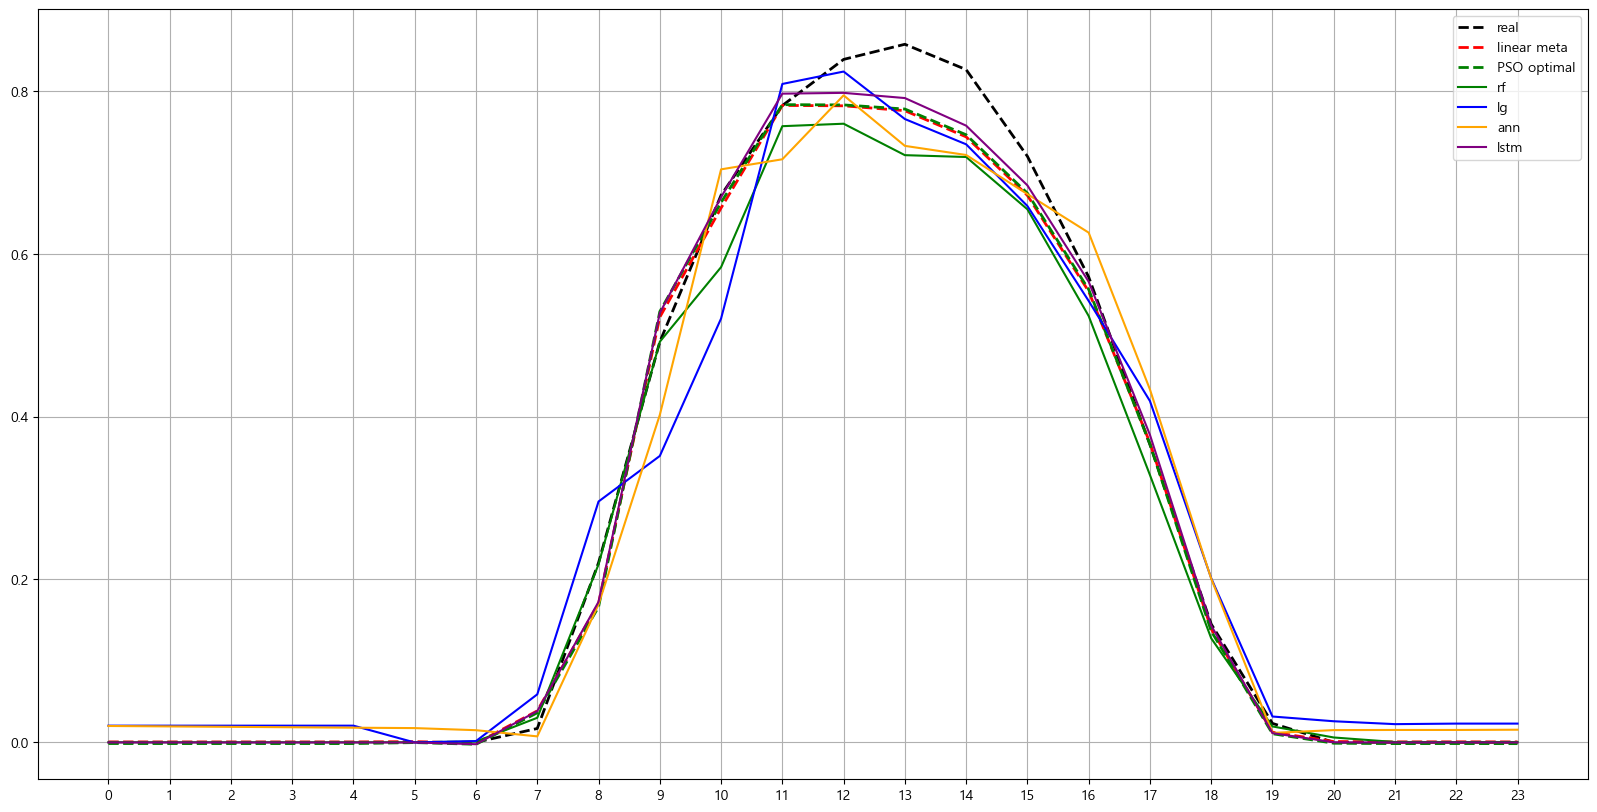

0.017882571828968373

In [576]:
i = 19
plt.figure(figsize=(20,10))
plt.plot(np.arange(24), y_test[i * 24 : 24*(i+1)], 'k--', linewidth=2)
plt.plot(np.arange(24), meta_result[i * 24 : 24*(i+1)], 'r--', linewidth=2)
plt.plot(np.arange(24), meta_result_2[i * 24 : 24*(i+1)], 'g--', linewidth=2)

plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),0], color = 'green')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),1], color = 'blue')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),2], color = 'orange')
plt.plot(np.arange(24), pd.DataFrame(predictions_array).iloc[i * 24 : 24*(i+1),3], color = 'purple')

plt.legend(['real','linear meta', 'PSO optimal','rf', 'lg', 'ann', 'lstm'])
plt.xticks(np.arange(24))
plt.grid()
plt.show()

mean_absolute_error(y_test[i * 24 : 24*(i+1)], meta_result[i * 24 : 24*(i+1)])

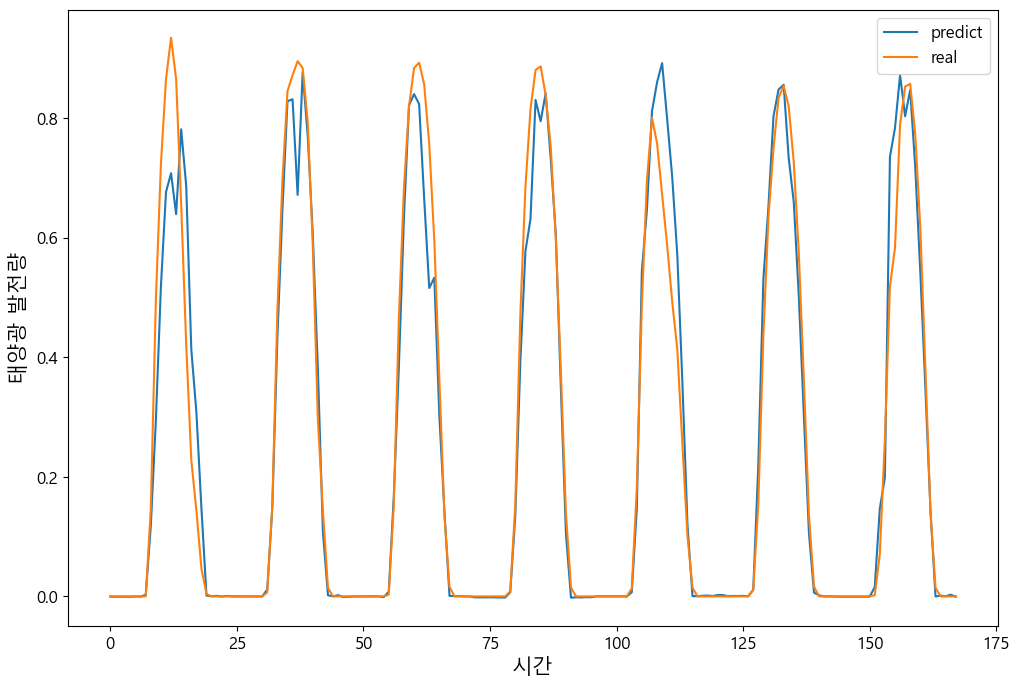

In [527]:
plt.figure(figsize=(12,8))
plt.plot(meta_result_2[:24*7], label = 'predict')
plt.plot(y_test[:24*7], label = 'real')
plt.legend(fontsize= 12)
plt.ylabel('태양광 발전량', fontsize = 15)
plt.yticks(fontsize = 12)
plt.xlabel('시간', fontsize = 15)
plt.xticks(fontsize= 12)
plt.show()

In [528]:
print('mse error (linear regression) : ',mean_squared_error(y_test, meta_result))
print('mae error (linear regression) : ',mean_absolute_error(y_test, meta_result))
print('mape error (linear regression) : ',mean_absolute_percentage_error(y_test, meta_result))

print('----------------------------------------------------')

print('mse error (PSO optimization) : ',mean_squared_error(y_test, meta_result_2))
print('mae error (PSO optimization) : ',mean_absolute_error(y_test, meta_result_2))
print('mape error (PSO optimization) : ',mean_absolute_percentage_error(y_test, meta_result_2))

print('----------------------------------------------------')

print('mse error (rf) : ',mean_squared_error(y_test, predictions_array[:,0]))
print('mae error (rf) : ',mean_absolute_error(y_test, predictions_array[:,0]))
print('mape error (rf) : ',mean_absolute_percentage_error(y_test, predictions_array[:,0]))

print('----------------------------------------------------')

print('mse error (lg) : ',mean_squared_error(y_test, predictions_array[:,1]))
print('mae error (lg) : ',mean_absolute_error(y_test, predictions_array[:,1]))
print('mape error (lg) : ',mean_absolute_percentage_error(y_test, predictions_array[:,1]))

print('----------------------------------------------------')

print('mse error (ann) : ',mean_squared_error(y_test, predictions_array[:,2]))
print('mae error (ann) : ',mean_absolute_error(y_test, predictions_array[:,2]))
print('mape error (ann) : ',mean_absolute_percentage_error(y_test, predictions_array[:,2]))

print('----------------------------------------------------')

print('mse error (LSTM) : ',mean_squared_error(y_test, predictions_array[:,3]))
print('mae error (LSTM) : ',mean_absolute_error(y_test, predictions_array[:,3]))
print('mape error (LSTM) : ',mean_absolute_percentage_error(y_test, predictions_array[:,3]))


mse error (linear regression) :  0.008477747572607974
mae error (linear regression) :  0.045399729634633505
mape error (linear regression) :  4447871761788.543
----------------------------------------------------
mse error (PSO optimization) :  0.008548423349008015
mae error (PSO optimization) :  0.045271672379532724
mape error (PSO optimization) :  3482257786692.507
----------------------------------------------------
mse error (rf) :  0.006375754288623332
mae error (rf) :  0.04201045054013475
mape error (rf) :  2617467695199.73
----------------------------------------------------
mse error (lg) :  0.006813307942156661
mae error (lg) :  0.04596611799506834
mape error (lg) :  10041466412752.922
----------------------------------------------------
mse error (ann) :  0.007264456148876265
mae error (ann) :  0.05000129620497195
mape error (ann) :  15871660546822.143
----------------------------------------------------
mse error (LSTM) :  0.008609210552649585
mae error (LSTM) :  0.045119363

In [529]:
peak_y_test = y_test.reshape(-1, 24)[:,11:14]

In [530]:
meta_y_test = meta_result.reshape(-1, 24)[:,11:14]
meta_y_2_test = meta_result_2.reshape(-1, 24)[:,11:14]
rf_y_test = predictions_array[:,0].reshape(-1, 24)[:,11:14]
lg_y_test = predictions_array[:,1].reshape(-1, 24)[:,11:14]
ann_y_test = predictions_array[:,2].reshape(-1, 24)[:,11:14]
lstm_y_test = predictions_array[:,3].reshape(-1, 24)[:,11:14]

In [531]:
print('Peak time error')
print('----------------------------------------------------')

print('mse error (linear regression) : ',mean_squared_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(meta_y_test)))
print('mae error (linear regression) : ',mean_absolute_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(meta_y_test)))

print('----------------------------------------------------')

print('mse error (PSO optimization) : ',mean_squared_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(meta_y_2_test)))
print('mae error (PSO optimization) : ',mean_absolute_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(meta_y_2_test)))

print('----------------------------------------------------')

print('mse error (rf) : ',mean_squared_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(rf_y_test)))
print('mae error (rf) : ',mean_absolute_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(rf_y_test)))

print('----------------------------------------------------')

print('mse error (lg) : ',mean_squared_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(lg_y_test)))
print('mae error (lg) : ',mean_absolute_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(lg_y_test)))

print('----------------------------------------------------')

print('mse error (ann) : ',mean_squared_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(ann_y_test)))
print('mae error (ann) : ',mean_absolute_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(ann_y_test)))

print('----------------------------------------------------')

print('mse error (LSTM) : ',mean_squared_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(lstm_y_test)))
print('mae error (LSTM) : ',mean_absolute_error(sc_y.inverse_transform(peak_y_test), sc_y.inverse_transform(lstm_y_test)))


Peak time error
----------------------------------------------------
mse error (linear regression) :  21616.388288954786
mae error (linear regression) :  102.42440948982615
----------------------------------------------------
mse error (PSO optimization) :  21746.96585493517
mae error (PSO optimization) :  102.29061706990005
----------------------------------------------------
mse error (rf) :  14854.90947409261
mae error (rf) :  98.23302452192338
----------------------------------------------------
mse error (lg) :  13979.080644411384
mae error (lg) :  91.26136804319485
----------------------------------------------------
mse error (ann) :  16491.759073020734
mae error (ann) :  106.648243028707
----------------------------------------------------
mse error (LSTM) :  21681.756835485834
mae error (LSTM) :  100.79115199497676


In [560]:
result_data = pd.DataFrame([meta_result,meta_result_2.astype('float64'), predictions_array[:,0], predictions_array[:,1], predictions_array[:,2].astype('float64'), predictions_array[:,3].astype('float64'), y_test.flatten()]).T

In [561]:
result_data.columns = ['stacking','weight', 'rf', 'lg', 'ann', 'lstm', 'real']

result_data.to_csv('stacking_result.csv', index=False)